In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os.path as osp

measurements = pd.read_csv('pca_version.txt', sep='\s+', names = ['wavelength', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2'])
central_wav = 15272

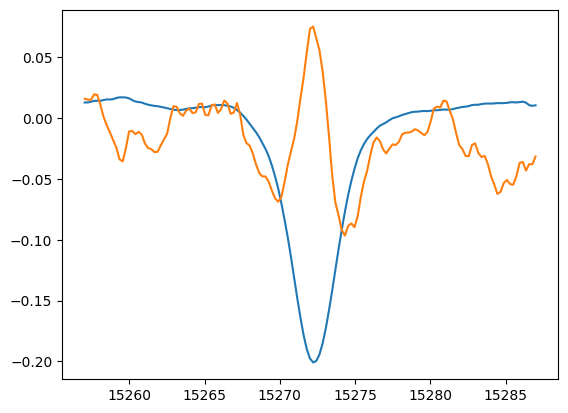

In [7]:
measurements['uncertainty'] = np.ones_like(measurements['PC1_1'])*0.1

plt.plot(measurements['wavelength'], measurements['PC1_1'])
plt.plot(measurements['wavelength'], measurements['PC2_2']*20)


In [8]:
base = osp.expanduser('~/../../scratch/gpfs/cj1223/')
# base = ''
orig = h5py.File(base+'pgo_outputs_original.h5', 'r')
eps = h5py.File(base+'pgo_outputs_epsilon.h5', 'r')

orig['spectra'][:].shape, eps['spectra'][:].shape, orig.keys(), orig['wavelengths'][:], orig['spectra'][:][:, 0, 0, 0, 0, 0],

((143, 4, 4, 9, 13, 19),
 (143, 4, 4, 9, 13, 19),
 <KeysViewHDF5 ['ab_values', 'c_values', 'fraction_ab', 'fraction_c', 'spectra', 'temperatures', 'wavelengths']>,
 array([15257.02999338, 15257.24077849, 15257.45156652, 15257.66235746,
        15257.87315131, 15258.08394807, 15258.29474775, 15258.50555034,
        15258.71635584, 15258.92716425, 15259.13797558, 15259.34878982,
        15259.55960697, 15259.77042703, 15259.98125001, 15260.19207589,
        15260.4029047 , 15260.61373641, 15260.82457104, 15261.03540858,
        15261.24624903, 15261.45709239, 15261.66793867, 15261.87878786,
        15262.08963997, 15262.30049498, 15262.51135291, 15262.72221376,
        15262.93307751, 15263.14394418, 15263.35481377, 15263.56568626,
        15263.77656167, 15263.98743999, 15264.19832123, 15264.40920538,
        15264.62009244, 15264.83098242, 15265.04187531, 15265.25277112,
        15265.46366983, 15265.67457146, 15265.88547601, 15266.09638347,
        15266.30729384, 15266.51820713, 1526

In [9]:
eps['temperatures'][:]

array([ 10.1,  15.1,  20.1,  25.1,  30.1,  35.1,  40.1,  45.1,  50.1,
        55.1,  60.1,  65.1,  70.1,  75.1,  80.1,  85.1,  90.1,  95.1,
       100.1])

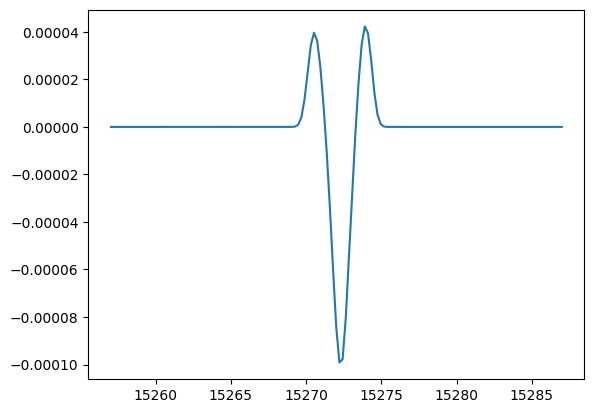

In [10]:
diff = eps['spectra'][:]-orig['spectra'][:]
plt.plot(eps['wavelengths'][:], diff[:, 1, 1, 0, 1, 1])

In [11]:
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

dT = True
edge = 25
gf = 0
measurement = measurements['PC1_1'][edge:-edge]
measurement_dT = measurements['PC2_2'][edge:-edge]

# Parameter grids
fraction_c_vals = orig['fraction_c'][:]
fraction_ab_vals = orig['fraction_ab'][:]
ab_vals = orig['ab_values'][:]
c_vals = orig['c_values'][:]
temperature_vals = orig['temperatures'][:]

# Prepare likelihood array: shape (FC, FAB, AB, C, T)
likelihoods = np.empty((
    len(fraction_c_vals),
    len(fraction_ab_vals),
    len(c_vals),
    len(ab_vals),
    len(temperature_vals)
))

for i_fc, fc in tqdm( enumerate(fraction_c_vals), total = len(fraction_c_vals)):
    for i_fab, fab in enumerate(fraction_ab_vals):
        for i_ab, ab in enumerate(ab_vals):
            for i_c, c in enumerate(c_vals):
                for i_t, t in enumerate(temperature_vals):
                    model_spec = orig['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t][edge:-edge]
                    model_spec = gaussian_filter(model_spec, gf)

                    M = np.vstack([model_spec, np.ones_like(model_spec)]).T
                    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
                    scalar, offset = coeffs

                    fit = scalar * model_spec + offset
                    residual = measurement - fit
                    chi2 = np.sum(residual ** 2)

                    if dT:
                        # Extract and smooth both spectra
                        spec = gaussian_filter(orig['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t][edge:-edge], gf)
                        model_spec = gaussian_filter(orig['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t][edge:-edge], gf) - \
                                     gaussian_filter(eps['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t][edge:-edge], gf)
    
                        # Build design matrix: [spec, model_spec, offset]
                        M = np.vstack([spec, model_spec, np.ones_like(spec)]).T
    
                        # Solve for two scalars and offset
                        coeffs, _, _, _ = np.linalg.lstsq(M, measurement_dT, rcond=None)
                        scalar1, scalar2, offset = coeffs
    
                        # Compute fit and residual
                        fit = scalar1 * spec + scalar2 * model_spec + offset
                        residual = measurement_dT - fit
    
                        chi2 += np.sum(residual ** 2)
                    
                    likelihoods[i_fc, i_fab, i_c, i_ab, i_t] = np.exp(-0.5 * chi2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:21<00:00, 65.48s/it]


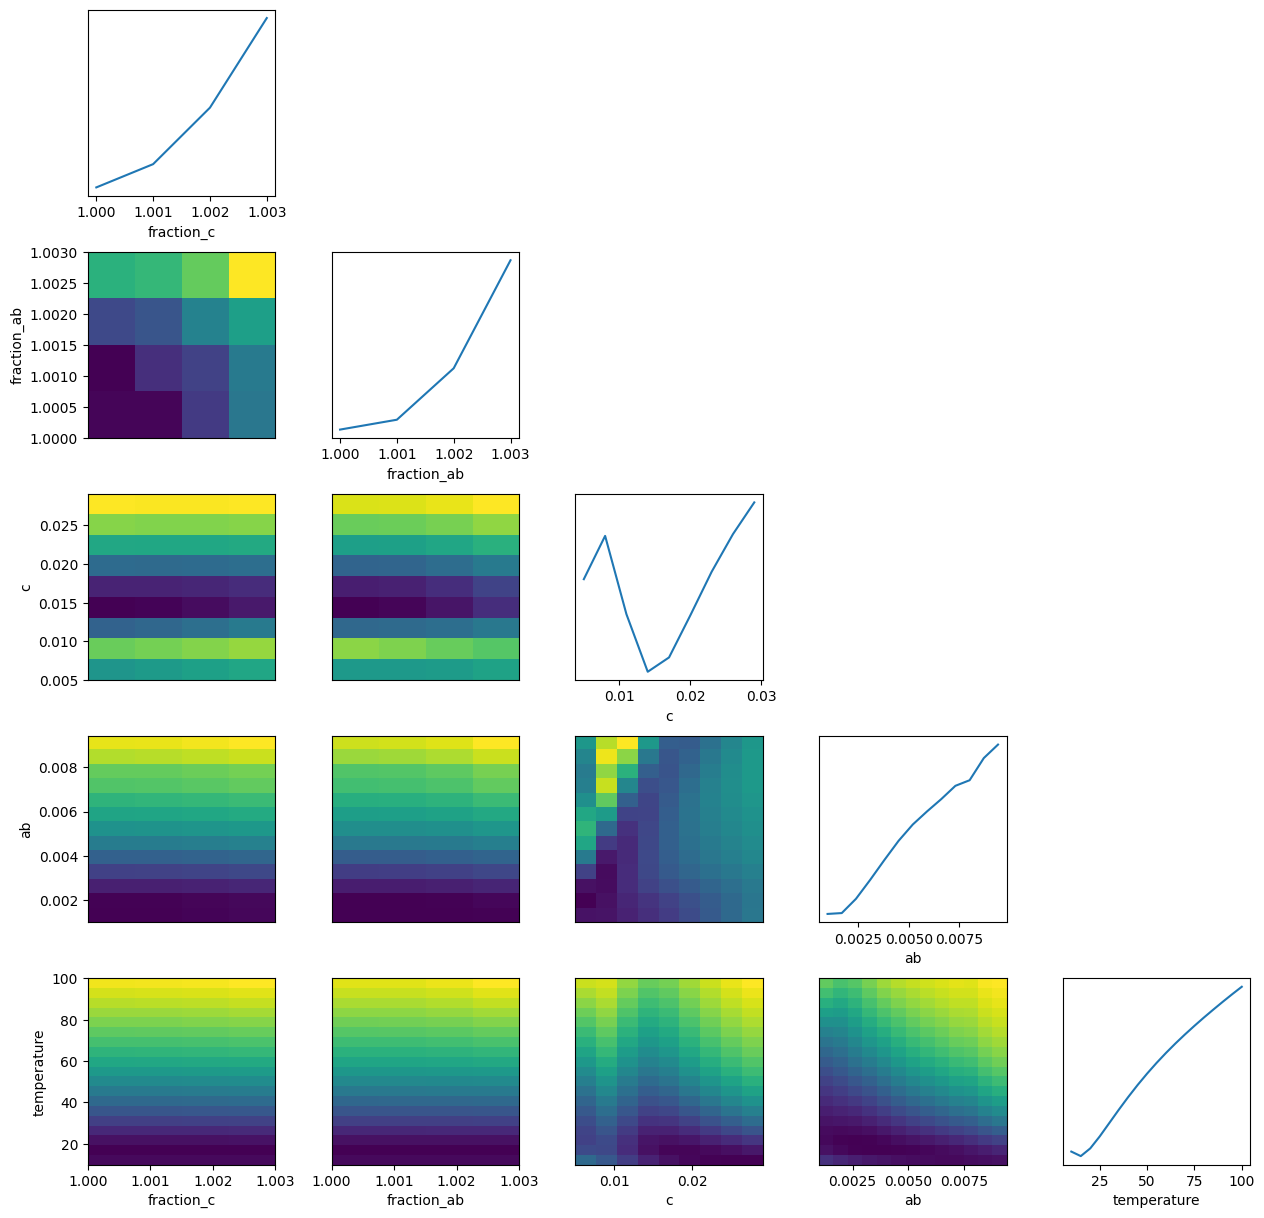

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# parameter arrays (for labels and axis ticks)
param_names = ['fraction_c', 'fraction_ab', 'c', 'ab', 'temperature']
param_vals = [fraction_c_vals, fraction_ab_vals, c_vals, ab_vals, temperature_vals]

ndim = 5

# Normalize likelihoods to sum to 1
likelihoods0 = np.copy(likelihoods)
likelihoods0 /= np.sum(likelihoods0)
likelihoods0 = -np.log(likelihoods0)

fig, axes = plt.subplots(ndim, ndim, figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]
        if i == j:
            # 1D marginal on diagonal (sum over all but this dim)
            marg = np.sum(likelihoods0, axis=tuple(k for k in range(ndim) if k != i))
            ax.plot(param_vals[i], marg)
            ax.set_xlabel(param_names[i])
            ax.set_yticks([])
        elif i > j:
            # 2D marginal for pairs (sum over all dims except i,j)
            marg2d = np.sum(likelihoods0, axis=tuple(k for k in range(ndim) if k != i and k != j))
            # Plot 2D histogram as imshow with origin='lower'
            im = ax.imshow(
                marg2d.T,  # transpose for correct orientation
                origin='lower',
                aspect='auto',
                extent=[param_vals[j][0], param_vals[j][-1], param_vals[i][0], param_vals[i][-1]],
                cmap='viridis'
            )
            if i == ndim-1:
                ax.set_xlabel(param_names[j])
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(param_names[i])
            else:
                ax.set_yticks([])
        else:
            ax.axis('off')

plt.show()


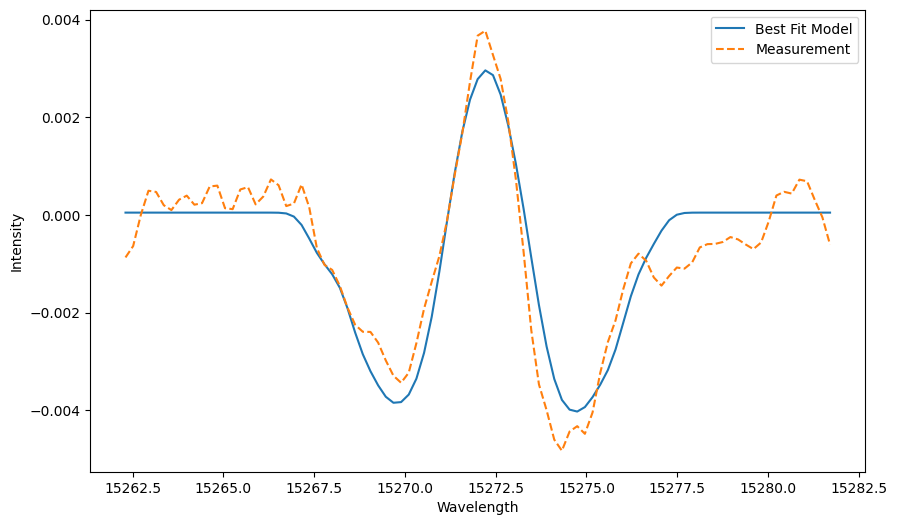


Best matching indices: (1, 0, 8, 3, 0)
Minimum L2 distance: 0.9990988581456737

Best fit parameter values:
Temperature: 10.0
A/B base value: 0.0031
C base value: 0.029
Fraction AB: 1.0
Fraction C: 1.001

Fitted model coefficients:
Scalar 1: -0.23531259053571618
Scalar 2: 83.34231015702404
Vertical offset: 4.6881110951875895e-05


In [13]:
# Find the indices of the best match (minimum distance)
c = 25
dc = 0
best_indices = np.unravel_index(np.argmin(likelihoods0), likelihoods0.shape)
# Extract the best spectra
best_spec = gaussian_filter(orig['spectra'][:, best_indices[0], best_indices[1], best_indices[2], best_indices[3], best_indices[4]][c+dc:-(c-dc)], gf)
best_diff_spec = best_spec - gaussian_filter(eps['spectra'][:, best_indices[0], best_indices[1], best_indices[2], best_indices[3], best_indices[4]][c+dc:-(c-dc)], gf)

# Fit best model to retrieve best scalars and offset
M_best = np.vstack([best_spec, best_diff_spec, np.ones_like(best_spec)]).T
best_coeffs, _, _, _ = np.linalg.lstsq(M_best, measurement_dT, rcond=None)
best_scalar1, best_scalar2, best_offset = best_coeffs

# Extract best-fit parameter values
best_temperature = orig['temperatures'][best_indices[-1]]
best_ab = orig['ab_values'][best_indices[-2]]
best_c = orig['c_values'][best_indices[-3]]
best_fraction_ab = orig['fraction_ab'][best_indices[-4]]
best_fraction_c = orig['fraction_c'][best_indices[-5]]

# Plot the best match
plt.figure(figsize=(10, 6))
plt.plot(orig['wavelengths'][c:-c], best_scalar1 * best_spec + best_scalar2 * best_diff_spec + best_offset, label='Best Fit Model')
plt.plot(orig['wavelengths'][c:-c], measurement_dT, label='Measurement', linestyle='--')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Print results
print("\nBest matching indices:", best_indices)
print("Minimum L2 distance:", likelihoods[best_indices])
print("\nBest fit parameter values:")
print(f"Temperature: {best_temperature}")
print(f"A/B base value: {best_ab}")
print(f"C base value: {best_c}")
print(f"Fraction AB: {best_fraction_ab}")
print(f"Fraction C: {best_fraction_c}")
print("\nFitted model coefficients:")
print(f"Scalar 1: {best_scalar1}")
print(f"Scalar 2: {best_scalar2}")
print(f"Vertical offset: {best_offset}")


In [15]:
83.34231015702404*0.1/0.3

27.780770052341353

In [20]:
((0.23/0.3)/11.2)*100, ((0.23)/11.2)*100

(6.845238095238096, 2.053571428571429)

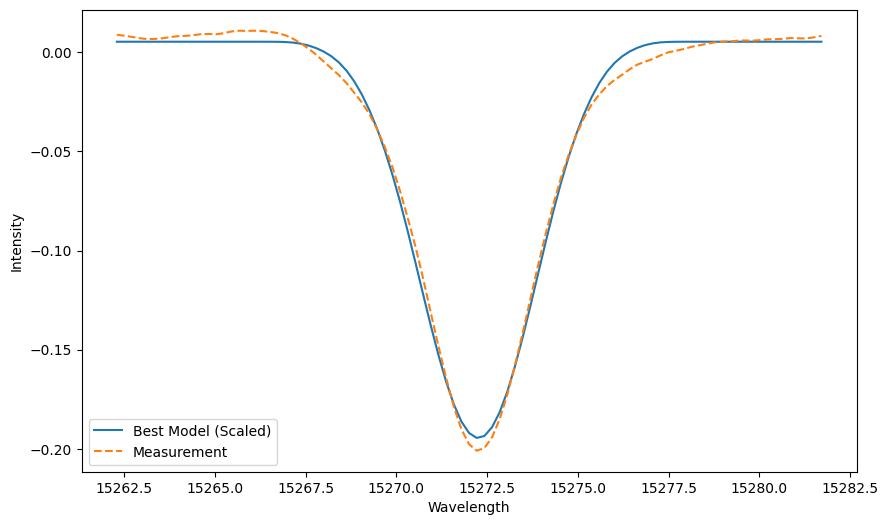


Best matching indices: (1, 0, 8, 3, 0)
Minimum L2 distance: 0.9990988581456737

Best fit parameter values:
Best scalar: -11.498645454693985
Temperature: 10.0
A/B base value: 0.0031
C base value: 0.029
Fraction AB: 1.0
Fraction C: 1.001


In [14]:
best_model_spec = gaussian_filter(orig['spectra'][:, best_indices[0], best_indices[1], best_indices[2], best_indices[3], best_indices[4]][c:-c], 1)
M = np.vstack([best_model_spec, np.ones_like(best_model_spec)]).T
coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
best_scalar, best_offset = coeffs

# Extract best-fit parameter values
best_temperature = orig['temperatures'][best_indices[-1]]
best_ab = orig['ab_values'][best_indices[-2]]
best_c = orig['c_values'][best_indices[-3]]
best_fraction_ab = orig['fraction_ab'][best_indices[-4]]
best_fraction_c = orig['fraction_c'][best_indices[-5]]

# Plot the best match
plt.figure(figsize=(10, 6))
plt.plot(orig['wavelengths'][c:-c], best_scalar * best_model_spec+best_offset, label='Best Model (Scaled)')
plt.plot(orig['wavelengths'][c:-c], measurement, label='Measurement', linestyle='--')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Print results
print("\nBest matching indices:", best_indices)
print("Minimum L2 distance:", likelihoods[best_indices])
print("\nBest fit parameter values:")
print(f"Best scalar: {best_scalar}")
print(f"Temperature: {best_temperature}")
print(f"A/B base value: {best_ab}")
print(f"C base value: {best_c}")
print(f"Fraction AB: {best_fraction_ab}")
print(f"Fraction C: {best_fraction_c}")